<div align=center><h1 style="display: inline;" >7. Checkpointing and Continuing Training (C1)</h1><img style="display: inline;" src=http://industrypulse.com/wp-content/uploads/2017/05/h2oai-1068x1068.png width=100></div>

It is often useful to continue training a model sometime in the future. For instance, this could occur when new data is recieved. Or, in a complex model (e.g. a deep neural net), training might have to be halted before completion. In that case, it's useful to have the ability to pick up where you left off.

Here we demonsrate how to save a trained H2O model, load it at a later time, and continue training.

**Loading the data:**

In [1]:
library(h2o)

h2o.init(nthreads=-1)
airlines_path = "../data/allyears2k.csv"
air.hex = h2o.importFile(path = airlines_path, destination_frame = "air.hex")
cat_features <- c("Month", "DayofMonth", "DayOfWeek")
num_cat_features <- length(cat_features)
for (i in 1:num_cat_features) {
   air.hex[cat_features[i]] <- as.factor(air.hex[cat_features[i]])
}

# Select features and target
features <- c(cat_features, "UniqueCarrier", "Distance", "Dest")
target <- "IsDepDelayed"

# Split frame
air.split <- h2o.splitFrame(air.hex, ratios = 0.8, seed = 12345)
air.train <- air.split[[1]]
air.valid <- air.split[[2]]


----------------------------------------------------------------------

Your next step is to start H2O:
    > h2o.init()

For H2O package documentation, ask for help:
    > ??h2o

After starting H2O, you can use the Web UI at http://localhost:54321
For more information visit http://docs.h2o.ai

----------------------------------------------------------------------


Attaching package: ‘h2o’

The following objects are masked from ‘package:stats’:

    cor, sd, var

The following objects are masked from ‘package:base’:

    &&, %*%, %in%, ||, apply, as.factor, as.numeric, colnames,
    colnames<-, ifelse, is.character, is.factor, is.numeric, log,
    log10, log1p, log2, round, signif, trunc



 Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         7 minutes 2 seconds 
    H2O cluster version:        3.14.0.6 
    H2O cluster version age:    9 days  
    H2O cluster name:           H2O_started_from_R_ec2-user_zal006 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   0.76 GB 
    H2O cluster total cores:    2 
    H2O cluster allowed cores:  2 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        54321 
    H2O Connection proxy:       NA 
    H2O Internal Security:      FALSE 
    H2O API Extensions:         XGBoost, Algos, AutoML, Core V3, Core V4 
    R Version:                  R version 3.4.1 (2017-06-30) 

  |======================================================================| 100%


**Training the model:** Let's start by training a gradient boosting machine to 

In [2]:
gbm_model <- h2o.gbm(x=features, y=target, model_id='gbm_model', training_frame=air.train, validation_frame=air.valid, ntrees=1000, score_each_iteration=TRUE, stopping_rounds=3, stopping_metric='logloss', stopping_tolerance=0.01)


  |======================================================================| 100%


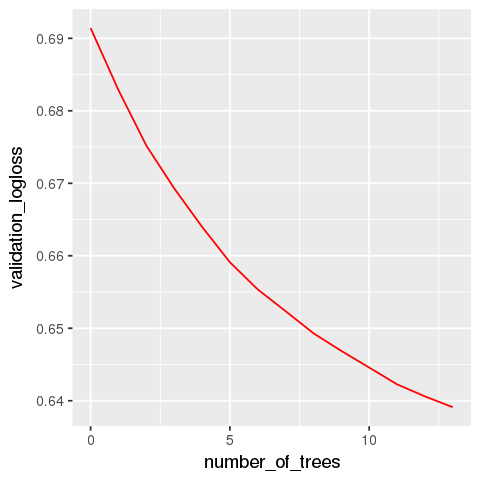

In [3]:
library(repr)
library(ggplot2)
options(repr.plot.width=4, repr.plot.height=4)
plot_df <- gbm_model@model$scoring_history[c('number_of_trees','validation_logloss')]
ggplot(aes(x = number_of_trees, y = validation_logloss), data = plot_df) + geom_line(color='red')

The stopping tolerance of 0.01 causes the training to abort prematurely, when the validation logloss (moving average) fails to exceed this amount.

In [4]:
ntrees_gbm_model <- gbm_model@model$model_summary["number_of_trees"][1,1]
ntrees_gbm_model

[1] 13

Now we save the model, restart H2O, and load the model for additional training:

In [5]:
h2o.saveModel(gbm_model, path="model1", force=TRUE)

[1] "/home/ec2-user/notebooks/model1/gbm_model"

In [6]:
h2o.shutdown()

Are you sure you want to shutdown the H2O instance running at http://localhost:54321/ (Y/N)? Y


In [7]:
library(h2o)

h2o.init(nthreads=-1)
airlines_path = "../data/allyears2k.csv"
air.hex = h2o.importFile(path = airlines_path, destination_frame = "air.hex")
cat_features <- c("Month", "DayofMonth", "DayOfWeek")
num_cat_features <- length(cat_features)
for (i in 1:num_cat_features) {
   air.hex[cat_features[i]] <- as.factor(air.hex[cat_features[i]])
}

# Select features and target
features <- c(cat_features, "UniqueCarrier", "Distance", "Dest")
target <- "IsDepDelayed"

# Split frame
air.split <- h2o.splitFrame(air.hex, ratios = 0.8, seed = 12345)
air.train <- air.split[[1]]
air.valid <- air.split[[2]]


H2O is not running yet, starting it now...

Note:  In case of errors look at the following log files:
    /tmp/Rtmph1LqXT/h2o_ec2_user_started_from_r.out
    /tmp/Rtmph1LqXT/h2o_ec2_user_started_from_r.err


Starting H2O JVM and connecting: .. Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         1 seconds 938 milliseconds 
    H2O cluster version:        3.14.0.6 
    H2O cluster version age:    9 days  
    H2O cluster name:           H2O_started_from_R_ec2-user_lle912 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   0.78 GB 
    H2O cluster total cores:    2 
    H2O cluster allowed cores:  2 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        54321 
    H2O Connection proxy:       NA 
    H2O Internal Security:      FALSE 
    H2O API Extensions:         XGBoost, Algos, AutoML, Core V3, Core V4 
    R Version:                  R version 3.4.1 (2017-06-30) 

  |===

In [8]:
gbm_model <- h2o.loadModel('model1/gbm_model')
ntrees_gbm_model <- as.numeric(gbm_model@model$model_summary["number_of_trees"])

In [18]:
gbm_model_checkpoint <- h2o.gbm(x=features, y=target, training_frame=air.train, model_id='gbm_model_checkpoint', validation_frame=air.valid, checkpoint='gbm_model', ntrees=100+ntrees_gbm_model, score_each_iteration=TRUE)

  |======================================================================| 100%


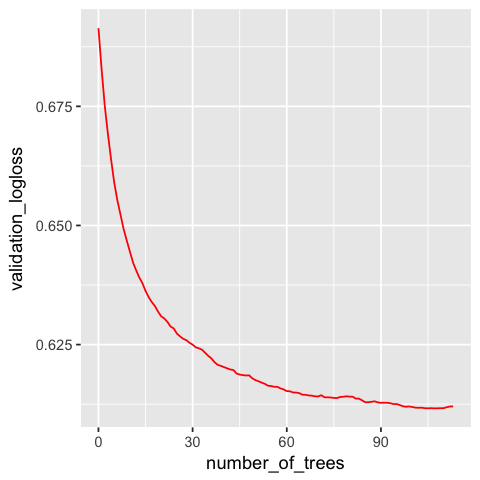

In [66]:
ggplot(data = gbm_model_checkpoint@model$scoring_history, aes(x = number_of_trees, y = validation_logloss)) + geom_line(color='red')

Here are the validation metrics after the second round of training:

In [54]:
gbm_model_checkpoint@model$validation_metrics

H2OBinomialMetrics: gbm
** Reported on validation data. **

MSE:  0.2120023
RMSE:  0.4604371
LogLoss:  0.612014
Mean Per-Class Error:  0.3844789
AUC:  0.7225382
Gini:  0.4450764

Confusion Matrix (vertical: actual; across: predicted) for F1-optimal threshold:
         NO  YES    Error        Rate
NO     1441 2713 0.653105  =2713/4154
YES     543 4144 0.115852   =543/4687
Totals 1984 6857 0.368284  =3256/8841

Maximum Metrics: Maximum metrics at their respective thresholds
                        metric threshold    value idx
1                       max f1  0.351844 0.717949 293
2                       max f2  0.172066 0.851087 376
3                 max f0point5  0.545724 0.687281 188
4                 max accuracy  0.507095 0.665196 210
5                max precision  0.983808 1.000000   0
6                   max recall  0.056943 1.000000 399
7              max specificity  0.983808 1.000000   0
8             max absolute_mcc  0.530868 0.330563 197
9   max min_per_class_accuracy  0.519